In [1]:
!nvidia-smi

Sat Apr 20 21:13:44 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  Off |
|  0%   49C    P8    21W / 450W |      0MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org display_tree
# !pip3 install requests==2.27.0
# !pip show requests

In [3]:
import os

os.environ["http_proxy"]  = "http://proxy.ad.speechpro.com:3128"
os.environ["https_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["ftp_proxy"]   = "http://proxy.ad.speechpro.com:3128"

# os.environ['CURL_CA_BUNDLE'] = ''

In [4]:
# from cutils import create_chunk_dataset, del_folder, load_checkpoint
from calc_content import create_hubert_content
from clustering import incremental_clustering, PseudoPhonemes
from dataset import Text2PseudoPhonemes, GraphemeTTSTokenizer, Text2SemanticCode
from models import TextEncoder, TransformerDecoder, Seq2Seq, WhisperX, SimpleSeq2SeqTransformer
from train import train, speech_editing, init_decoder, init_textencoder, init_dataset, sentense_speech_editing
from cutils import del_folder, create_chunk_dataset

from pathlib import Path
from typing import *
import json
import pprint

import whisperx
import matplotlib.pyplot as plt
import wget
import torch
from safetensors.torch import load_file
from torch.utils.data import DataLoader
import numpy as np

from IPython.display import Audio

%matplotlib inline


# !pip install anyascii
            #  gruut
            #  bnunicodenormalizer
            #  bnnumerizer
            #  bangla
            #  inflect
            #  jamo
            #  jieba
            #  pypinyin
            # mutagen
# from TTS.tts.utils.text.tokenizer import TTSTokenizer
# from TTS.tts.configs.vits_config import VitsConfig


def path(_path):
    return "./examples/" / Path(_path)


import os
os.environ['TRANSFORMERS_CACHE'] = "/mnt/storage/kocharyan/hfmodels"

  torchaudio.set_audio_backend("soundfile")



You run simple transformer exp


### Create test dataset

In [10]:
!ls examples/rudevices_chunk/

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
create_chunk_dataset("../../NIR/RuDevices", out_dataset=path("rudevices_chunk"), display=True, k=10)

In [ ]:
# !ls examples/rudevices_chunk/1/1/

In [ ]:
# git clone lengyue233/content-vec-best

In [ ]:
# !mkdir ../../hfmodels
# download_hf_model("lengyue233/content-vec-best", "../../hfmodels") #TODO: Add final proj layer in lengyue233/content-vec-best

### Create HuBERT contents & Clustering

In [ ]:
# !mv examples/extracted_contents/ examples/extracted_contents_v2/
!ls examples/

clusters  extracted_contents  extracted_contents_v2  res  rudevices_chunk


In [5]:
#TODO: Add final proj layer in lengyue233/content-vec-best
del_folder(path("extracted_contents"))
create_hubert_content(
    data_dir=path("rudevices_chunk"), out_dir=path("extracted_contents"), 
    njobs=5, pretrain_path="../../hfmodels/content-vec-best",
    )

n_jobs=5
{'hmodel_id': '../../hfmodels/content-vec-best', 'data_sr': 16000, 'out_dir': PosixPath('examples/extracted_contents'), 'device': 'cuda', 'rel_to': PosixPath('examples/rudevices_chunk')}


/mnt/driveb/kocharyan/virtual_environments/superenv/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/mnt/driveb/kocharyan/virtual_environments/superenv/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/mnt/driveb/kocharyan/virtual_environments/superenv/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/mnt/driveb/kocharyan/virtual_environments/superenv/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.wa

In [7]:
incremental_clustering(
    path("extracted_contents"), path("clusters/clusters.pt"),
    n_clusters=200, batch_size=5, data_pattern="*.content.pt"
    )

100%|██████████| 347/347 [00:02<00:00, 170.18it/s]

Clustering time 2.05 seconds
Data size: 314105 vectors, 306.74 MB


In [ ]:
cluster = PseudoPhonemes(path("clusters/clusters.pt"))
cluster.build_clusters()

In [ ]:
data = torch.load(path("clusters/clusters.pt"))
print(data['cluster_centers'].shape)
item = (data['cluster_centers'][50] + data['cluster_centers'][25]).reshape(1, -1)
print(cluster.predict_cluster_center(item))
print(cluster.get_cluster_center(item).shape)

(100, 256)
[50]
(1, 256)


In [ ]:
!ls ../../hfmodels/content-vec-best

config.json  convert.py  pytorch_model.bin  README.md


### Prepare Dataset

#### Тетстируем GraphemeTTSTokenizer/PseudoPhones-encoding/Text2SemanticCode

In [ ]:
symbols_dict = {
    "pad" : '_',
    "eos": "*",
    "bos": "&",
    "punctuation": ' !,-.?',
    "letters": 'абвгдежзийклмнопрстуфхцчшщъыьэюяё',
}

tokenizer = GraphemeTTSTokenizer(
    characters=symbols_dict["letters"], punctuations=symbols_dict["punctuation"], 
    pad=symbols_dict["pad"], eos=symbols_dict['eos'], bos=symbols_dict["bos"], 
    blank=None, processor=GraphemeTTSTokenizer.text_processor,
    )

encoded = tokenizer.encode("скачок который видел в начале графика")
print(encoded, sep='\t')

print(tokenizer.decode(encoded), sep='\t')


[2, 20, 13, 3, 26, 17, 13, 36, 13, 17, 21, 17, 19, 30, 12, 36, 5, 11, 7, 8, 14, 36, 5, 36, 16, 3, 26, 3, 14, 8, 36, 6, 19, 3, 23, 11, 13, 3, 1]
скачок который видел в начале графика


In [ ]:
cluster = PseudoPhonemes(path("clusters/clusters.pt"))
cluster.build_clusters()
cluster.on_labling_mode()
encoded = cluster.encode([3, 67, 8])
cluster.size, encoded, cluster.decode(encoded)

(100, [101, 3, 67, 8, 102], [3, 67, 8])

In [ ]:
dataset = Text2SemanticCode(
    texts_path=path("rudevices_chunk"), contents_path=path("extracted_contents"), 
    clusters_path=path("clusters/clusters.pt"), tokenizer_conf=None, dsrate=16_000,
    )
batch = next(iter(DataLoader(dataset, batch_size=1, collate_fn=dataset.collate_fn)))
batch

Texts prepared!
Contents prepared!


{'tokens_padded': tensor([[ 1, 16,  3, 36, 21, 19, 11,  7, 25,  3, 21, 31, 36, 26,  3, 20, 17,  5,
           2]]),
 'lables': tensor([[101,   3,  86,  86,   4,  12,  12,  12,  12,  12,  12,  12,  52,  52,
           50,  94,  18,  65,  75,  75,  75,  32,  32,  72,   6,  88,  88,  95,
           83,  83,  83,   5,   5,   5,   5,  59,  59,  70,  69,  30,  30,  30,
            5,  59,  59,  23,  23,  23,  23,  23,  40,  40,  40,  40,  81,  81,
           81,  81,  81,  33,  33,  33,  33,  33,  33,  33,  33,  33,   9,   9,
            9,   9,   9,   9,   9,   9,   9,  19,  19,  19,  19,  19,  19,  19,
           19,  19,  19,  19,  19,  28,  28,  28,  34,  28,  28,  28,  28,  28,
           34,  28,  28,  28,  34,  44,  44,  44,   3,   3, 102]]),
 'text_lens': None}

In [ ]:
dataset.text_tokenizer.size, cluster.vocab_size

(42, 103)

In [ ]:
model = SimpleSeq2SeqTransformer(
    num_enc=3, num_dec=2, emb_size=128, nhead=4, dim_ff=256,
    src_vocab=dataset.text_tokenizer.size, tgt_vocab=cluster.vocab_size,
    )

src_mask = torch.ones(batch['tokens_padded'].size())
tgt_mask = torch.ones(batch['lables'].size())

assert tgt_mask.size() ==  batch['lables'].size()
assert src_mask.size() == batch['tokens_padded'].size()

print(f"{batch['lables'].shape=}\t{batch['tokens_padded'].shape=}")
model(batch['tokens_padded'], batch['lables'], src_mask, tgt_mask).shape

batch['lables'].shape=torch.Size([1, 109])	batch['tokens_padded'].shape=torch.Size([1, 19])


torch.Size([1, 109, 103])

In [ ]:
batch = next(iter(DataLoader(dataset, batch_size=2, collate_fn=dataset.collate_fn)))
batch['lables'].shape, batch['lables'][:, :-1].shape

(torch.Size([2, 109]), torch.Size([2, 108]))

#### Other


In [ ]:
# conf_p = "../../NIR/YourTTS-RU-RUSLAN-April-30-2023_03+48PM-0000000/config.json"
dataset = Text2PseudoPhonemes(
    path("rudevices_chunk"), path("extracted_contents"), path("clusters/clusters.pt"), 
    None, None, "ckpts/yourrtts_config.json", #pretrain path m.b. "../../hfmodels/content-vec-best"
    )

In [ ]:
# batch = next(iter(dataset))
# batch['pseudo_ph'].shape, 

# batch = next(iter(DataLoader(dataset, batch_size=2, collate_fn=lambda x: x)))

# batch = next(iter(DataLoader(dataset, batch_size=2, collate_fn=dataset.collate_fn)))
# batch['tokens_padded'].shape, batch['lables'].shape, 

# !mkdir ckpts
# !cp ../../NIR/YourTTS-RU-RUSLAN-April-30-2023_03+48PM-0000000/best_model_158996.pth ckpts/yourtts_ruslan.pth

In [ ]:
len(dataset.tokenizer.characters.vocab)

177

In [ ]:
n_vocab         = len(dataset.tokenizer.characters.vocab) # 177
inter_channels  = 192
hidden_channels = 192
filter_channels = 768
n_heads         = 2
n_layers        = 10 # 6/10 for YourTTS
kernel_size     = 3
p_dropout       = .1

prior_encoder = TextEncoder(
    n_vocab, inter_channels, hidden_channels, filter_channels, 
    n_heads, n_layers, kernel_size, p_dropout,
)   

In [ ]:
prior_encoder, conf = load_checkpoint(prior_encoder,
                                "ckpts/yourtts_ruslan.pth", 
                                "text_encoder", False)

  return self.fget.__get__(instance, owner)()



In [ ]:
batch = next(iter(DataLoader(dataset, batch_size=1, collate_fn=dataset.collate_fn)))
batch

{'tokens_padded': tensor([[140, 127, 175, 145, 143, 135, 131, 149, 127, 145, 155, 175, 150, 127,
          144, 141, 129]]),
 'lables': tensor([[100,  68,  44,  44,  86,  91,  91,  22,  22,  22,  22,  22,  22,  77,
           48,  10,   9,  27,  78,  78,  78,  39,  39,  75,  42,  72,  72,  72,
           55,  55,  13,  13,  13,  13,  79,  79,  98,  61,  61,  61,  61,  61,
           45,  45,  45,  66,  66,  66,  66,  66,  40,  40,  40,  40,  34,  34,
           34,  34,  34,   6,   6,   6,   6,   6,   6,   6,   6,   6,  81,  81,
           81,  81,  81,  81,  81,  81,  24,  24,  24,  24,  24,  24,  24,  24,
           87,  87,  87,  87,  87,  87,  87,  87,  68,  49,  49,  49,  49,  49,
           68,  49,  49,  49,  68,  49,  14,  14,   0,   0, 101]]),
 'text_lens': tensor([17])}

In [ ]:
import numpy as np
np.ones((3, 4))[:-1, :].shape

(2, 4)

In [ ]:
batch = next(iter(DataLoader(dataset, batch_size=3, collate_fn=dataset.collate_fn)))
print(batch["lables"].shape)
print(batch["lables"][:, :-1].shape)

torch.Size([3, 314])
torch.Size([3, 313])


In [ ]:
batch = next(iter(DataLoader(dataset, batch_size=3, collate_fn=dataset.collate_fn)))
print(f"{batch['tokens_padded'].shape=}")
enc_out = prior_encoder(batch["tokens_padded"], batch["text_lens"])[0]#.permute((0, 2, 1))
enc_out.shape

batch['tokens_padded'].shape=torch.Size([3, 98])


torch.Size([3, 192, 98])

In [ ]:
decoder = TransformerDecoder(1, 192, 300, 1, dataset.gen_pad + 1, .1, dataset.gen_pad, dataset.gen_bos, dataset.gen_eos) #TODO dataset.gen_pad + 1
decoder(enc_out, batch['lables']).shape, batch['lables'].shape

(torch.Size([3, 314, 103]), torch.Size([3, 314]))

In [ ]:
seq2seq = Seq2Seq(prior_encoder, decoder)
seq2seq(batch).shape

torch.Size([3, 314, 103])

### Train

In [ ]:
mask = (torch.triu(torch.ones((5, 5))) == 1).float()
print(mask)
mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
print(mask)
mask.transpose(0, 1)

tensor([[1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]])
tensor([[0., 0., 0., 0., 0.],
        [-inf, 0., 0., 0., 0.],
        [-inf, -inf, 0., 0., 0.],
        [-inf, -inf, -inf, 0., 0.],
        [-inf, -inf, -inf, -inf, 0.]])


tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [ ]:
losses, model, dataset = train() #simple encoder-decoder

Text2SemanticCode dataset prepared
Texts prepared!
Contents prepared!
SimpleSeq2SeqTransformer prepared
Epoch: 1, Train loss: 5.529370625813802, Time: 1.479 min
Epoch: 26, Train loss: 3.490570306777954, Time: 37.039 min
Epoch: 51, Train loss: 2.6387027899424234, Time: 73.010 min
Epoch: 76, Train loss: 2.348296562830607, Time: 109.622 min
Epoch: 101, Train loss: 2.2137744426727295, Time: 145.144 min
Epoch: 126, Train loss: 2.141319235165914, Time: 180.496 min
Epoch: 151, Train loss: 2.091518441836039, Time: 215.928 min
Epoch: 176, Train loss: 2.056012272834778, Time: 251.192 min
Epoch: 201, Train loss: 2.0283350745836892, Time: 286.547 min
Epoch: 226, Train loss: 2.0042814215024314, Time: 321.899 min


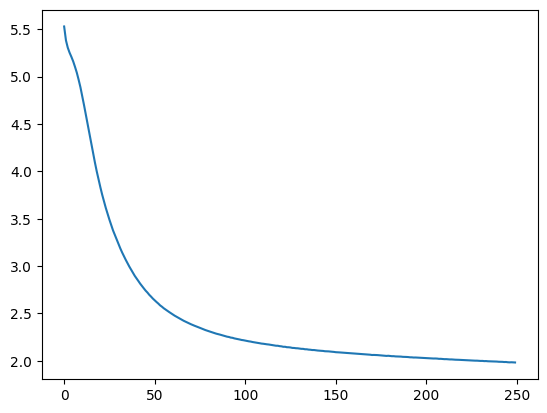

In [ ]:
plt.plot(losses)
plt.show() #0.7

In [ ]:
torch.save(model.state_dict(), "ckpts/seq2seq_v3.pkl")

In [ ]:
# losses, model, dataset = train() #simple encoder-decoder (w/o transpose tgt mask)
# plt.plot(losses)
# plt.show() #None

In [ ]:
# losses, model, dataset = train() # yourtts-decoder ?
# plt.plot(losses)
# plt.show()

### Decoding

#### Other

In [ ]:
whisperx_model = WhisperX() 

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.2+cu118. Bad things might happen unless you revert torch to 1.x.


Some weights of the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.p

In [ ]:
!ls ./examples/rudevices_chunk/2/b/

2ea73463-c1e5-4d4f-93a6-055f6ef159cb.txt
2ea73463-c1e5-4d4f-93a6-055f6ef159cb.wav
316cb6f3-5974-4371-a868-2c531a3087e8.txt
316cb6f3-5974-4371-a868-2c531a3087e8.wav
dc080bc6-089d-4f6d-b033-1d867e747a3a.txt
dc080bc6-089d-4f6d-b033-1d867e747a3a.wav
dd9262b6-bb56-4ffa-9458-2790458ce27e.txt
dd9262b6-bb56-4ffa-9458-2790458ce27e.wav


In [ ]:
Audio("./examples/rudevices_chunk/2/b/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav", rate=16_000)

In [ ]:
!cat ./examples/rudevices_chunk/2/b/dd9262b6-bb56-4ffa-9458-2790458ce27e.txt #--> скачок который видел в конце графика

скачок который видел в начале графика

In [ ]:
bp = "./examples/rudevices_chunk/2/b/"
audio = WhisperX.load_audio(bp+'dd9262b6-bb56-4ffa-9458-2790458ce27e.wav')
out = whisperx_model(audio)
alignment = WhisperX.postprocess_out(out, by='words')
alignment

Detected language: ru (0.99) in first 30s of audio...


[{'word': 'Скачок,', 'start': 0.089, 'end': 0.532, 'score': 0.919},
 {'word': 'который', 'start': 0.572, 'end': 0.874, 'score': 0.927},
 {'word': 'виден', 'start': 0.914, 'end': 1.135, 'score': 0.552},
 {'word': 'в', 'start': 1.155, 'end': 1.175, 'score': 1.0},
 {'word': 'начале', 'start': 1.215, 'end': 1.557, 'score': 0.984},
 {'word': 'графика.', 'start': 1.618, 'end': 2.08, 'score': 1.0}]

In [ ]:
out['segments'][0]['text']

' Скачок, который виден в начале графика.'

In [ ]:
WhisperX.formed_timesteps(alignment)

{0: ('скачок,', [range(4, 27)]),
 1: ('который', [range(28, 44)]),
 2: ('виден', [range(45, 57)]),
 3: ('в', [range(57, 59)]),
 4: ('начале', [range(60, 78)]),
 5: ('графика.', [range(80, 105)])}

In [ ]:
torch.save(model.state_dict(), "ckpts/seq2seq.pkl")

In [ ]:
dataset = init_dataset()
encoder, decoder = init_textencoder(dataset), init_decoder(dataset)
model = Seq2Seq(encoder, decoder)
model.load_state_dict(torch.load("ckpts/seq2seq.pkl"))
model.eval();


#### Checking Systema

С чем надо разбираться дальше?

- Декодировать предсказания модели через Clusters
- Получить для данных меток непосредственно центры кластеров
- Подменить в инференсы со-витс (интерфейс уже есть)
- Декодирование норм работает ?
- 

In [5]:
# !ls ./examples/rudevices_chunk/3/d/

In [ ]:
!cat ./examples/rudevices_chunk/3/d/827ff1be-f155-48dd-884d-dc7b36d3e4b8.txt
# !cat ./examples/rudevices_chunk/3/0/a1cbf966-f032-4665-97f3-4b54206bf5ff.txt
Audio("./examples/rudevices_chunk/3/d/827ff1be-f155-48dd-884d-dc7b36d3e4b8.wav", rate=16_000)

принимаете заказ как положено он мне звонил мы с ним договорились что можно сделать на ложках тем более там сумма на ложки

In [ ]:
# bp = "../../NIR/RuDevices/2/b/"
# audio_f = bp+'dd9262b6-bb56-4ffa-9458-2790458ce27e.wav'
# src_text = 'принимаете заказ как положено он мне звонил мы с ним договорились что можно сделать на ложках тем более там сумма на ложки'
# target_text = 'принимаете заказ как положено он мне написал мы с ним договорились что можно сделать на ложках тем более там сумма на ложки'
!cat ../../NIR/RuDevices/2/b/dd9262b6-bb56-4ffa-9458-2790458ce27e.txt

скачок который видел в начале графика

In [5]:
# bp = "./examples/rudevices_chunk/3/d/"
# audio_f = bp+'827ff1be-f155-48dd-884d-dc7b36d3e4b8.wav'
bp = "../../NIR/RuDevices/2/b/"
audio_f = bp+'dd9262b6-bb56-4ffa-9458-2790458ce27e.wav'
src_text = "скачок который видел в начале графика"
target_text = "падение который видел в начале графика"
model = "ckpts/seq2seq_v3.pkl"

preds = speech_editing(audio_f, src_text, target_text, None, model)
# sentense_speech_editing(audio_f, src_text, target_text, None, model)

Some weights of the model checkpoint at /mnt/storage/kocharyan/hfmodels/content-vec-best were not used when initializing HubertModelWithFinalProj: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModelWithFinalProj from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModelWithFinalProj from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModelWithFinalProj were not initialized from the model checkpoint at /mnt/storage/kocharyan/hfmodels/content-vec-best and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.ori

No language specified, language will be first be detected for each audio file (increases inference time).


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../home/stc/.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.2+cu118. Bad things might happen unless you revert torch to 1.x.


Some weights of the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at /mnt/storage/kocharyan/hfmodels/wav2vec2-large-xlsr-53-russian/ and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.p

Detected language: ru (0.99) in first 30s of audio...
DEBUG timesteps={0: ('скачок,', range(4, 27)), 1: ('который', range(28, 44)), 2: ('виден', range(45, 57)), 3: ('в', range(57, 59)), 4: ('начале', range(60, 78)), 5: ('графика.', range(80, 105))}
Text2SemanticCode dataset prepared
Texts prepared!
Contents prepared!
падение : [1, 18, 3, 7, 8, 16, 11, 8, 2]
Decoding: target_text='падение'
token_ids.shape=torch.Size([1, 9]), num_tokens=9
Decoding: ref_text='скачок'
Decoding: ref_text='скачок,' (GT), range=range(4, 27)
contents.shape=torch.Size([1, 134, 256]), contents[:, idxs].shape=torch.Size([1, 23, 256])


Some weights of the model checkpoint at /mnt/storage/kocharyan/hfmodels/content-vec-best were not used when initializing HubertModelWithFinalProj: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModelWithFinalProj from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModelWithFinalProj from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModelWithFinalProj were not initialized from the model checkpoint at /mnt/storage/kocharyan/hfmodels/content-vec-best and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.ori

Replaced for  падение
=====> SVCInfer works ...
input_paths=[PosixPath('../../NIR/RuDevices/2/b/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav')], output_paths=[PosixPath('examples/res/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav')]
new_c.shape=(108, 256)
f0.shape=torch.Size([1, 310]) c.shape=torch.Size([1, 256, 310])
Inference time: 0.66s, RTF: 0.18


In [6]:
Audio(audio_f, rate=16_000)

In [7]:
# !rm examples/res/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav
!ls examples/res/

0f916af2-27c2-4536-9379-7781612c2afa.wav
827ff1be-f155-48dd-884d-dc7b36d3e4b8.wav
a1cbf966-f032-4665-97f3-4b54206bf5ff.wav
dd9262b6-bb56-4ffa-9458-2790458ce27e.wav


In [8]:
# Используем нули
Audio("examples/res/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav", rate=16_000)

In [8]:
# Используем кластера
Audio("examples/res/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav", rate=16_000)

### other

In [ ]:
# C изменением f0
Audio("examples/res/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav", rate=16_000)

In [ ]:
# Без  изменения f0
Audio("examples/res/dd9262b6-bb56-4ffa-9458-2790458ce27e.wav", rate=16_000)

In [ ]:
# DEBUG: src_emb.shape=torch.Size([1, 36, 192]) tgt_emb.shape=torch.Size([2, 1, 192])
# DEBUG: src_emb.shape=torch.Size([16, 98, 192]) tgt_emb.shape=torch.Size([16, 344, 192])

# dim = np.stack(preds[6]['tgt centriods'], axis=0).shape
# dim_0 = dim[0] 
# dim_1 = dim[1]
# assert dim_0 == len(preds[6]['tgt_preds (написал)'])
# assert dim_1 == 256

In [ ]:
# arr = [1, 2, 3, 4] # -> [1, 1, 2, 2, 3, 3, 4, 4]
# n = 2
# tgt = [] # 0 for _ in range(len(arr) * n)
# for i in range(len(arr)):
#     for _ in range(n):
#         tgt.append(arr[i])
# tgt

In [ ]:
300 - 115

185

### Big clusters

In [11]:
! ls ../../NIR/RuDevices/

0  1  2  3  4  5  6  7	8  9  a  b  c  d  e  f


In [1]:
# create_hubert_content(
#         data_dir="../../NIR/RuDevices/", out_dir="../../NIR/RuDevices_extracted_contents", 
#         njobs=5, pretrain_path="../../hfmodels/content-vec-best",
#     )